# Create Environment

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=100

global T
global target
global theta_0
T=8.5
target=3.88
theta_0=-0.11318
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

C:\Users\ChangWeiYueh\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


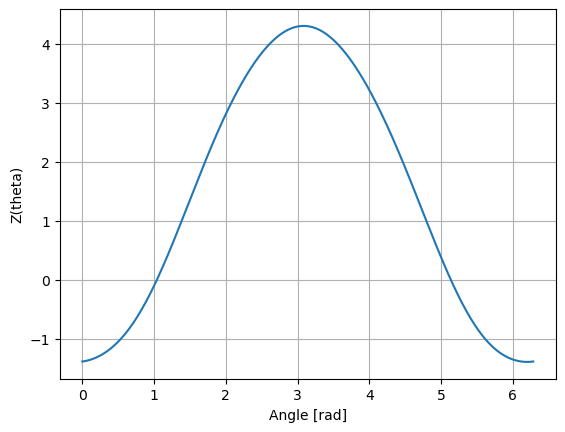

In [2]:
def Z(theta):
    return 1.417-2.9006*np.cos(theta)+0.0217*np.cos(2*theta)+0.0603*np.cos(3*theta)+0.02148*np.cos(4*theta)+0.1624*np.sin(theta)
    +0.4248*np.sin(theta)+0.0553*np.sin(3*theta)-0.0126*np.sin(4*theta)

#check the correctness of Z
x = np.linspace(0, 2*np.pi, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()

In [3]:
def next_step_and_reward(theta_k,u_k):
    theta_new=theta_k+delta_t*(w+Z(theta_k)*u_k)
    while theta_new>1.5*np.pi:
        theta_new-=2*np.pi
    while theta_new<-0.5*np.pi:
        theta_new+=2*np.pi
    return theta_new, -(theta_new-target)**2
    #return theta_new, -0.5*(theta_new-target)**2+abs(theta-target)-abs(theta_new-target)

def reward(theta_k):
    return -(theta_k-target)**2



# Learning Settings

In [4]:
global lr
lr=0.01
global eps
eps=0.1
global max_u
max_u=1
global precision
precision=0.0002
def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    ind=np.argmax(cand)
    possible=np.linspace(0, max_u, int(max_u/precision+1))
    return possible[ind]
    
def decide_u(theta,cand,init=False):
    explo=exploration()
    if init or explo:
        possible=np.linspace(0, max_u,  int(max_u/precision+1))
        return(possible[np.random.randint( int(max_u/precision+1))])
    else:
        return(find_max(cand))
    
def generate_cand(theta):
    possible=np.linspace(0, max_u,  int(max_u/precision+1))
    cand=[]
    for i in range( int(max_u/precision+1)):
        cand.append([theta,possible[i]])
    return np.array(cand)

history_su=np.array([[]])
history_r=np.array([])
possible_u=np.linspace(0, max_u,  int(max_u/precision+1))

# Simulation


In [5]:
num_iter=100

theta_result=[]
for iterr in tqdm(range(num_iter)):
    #initialize
    theta=theta_0
    u_t=[]
    theta_t=[theta_0]
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            u_k = decide_u(theta,candidates_u,init=True)
            theta_new, r = next_step_and_reward(theta,u_k)
            if time==0:
                history_su = np.array([theta,u_k]).reshape(1,-1)
            else:
                history_su = np.concatenate((history_su, np.array([theta,u_k]).reshape(1,-1)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta=theta_new
            u_t.append(u_k)
        elif iterr>10:  
            eps=0
            x_cand = generate_cand(theta)
            candidates_u, std_u = gpr.predict(x_cand.reshape(-1,2), return_std=True)
            u_k = decide_u(theta,candidates_u)
            theta_new, r = next_step_and_reward(theta,u_k)
            history_su = np.concatenate((history_su, np./array([theta,u_k]).reshape(-1,2)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta = theta_new
            u_t.append(u_k)
            theta_t.append(theta)
        else:            
            x_cand = generate_cand(theta)
            candidates_u, std_u = gpr.predict(x_cand.reshape(-1,2), return_std=True)
            u_k = decide_u(theta,candidates_u)
            theta_new, r = next_step_and_reward(theta,u_k)
            history_su = np.concatenate((history_su, np.array([theta,u_k]).reshape(-1,2)))
            history_r = np.concatenate((history_r,np.array([r])))
            theta = theta_new
            u_t.append(u_k)
            theta_t.append(theta)
    gpr = GaussianProcessRegressor(alpha=1e-8).fit(history_su, history_r.reshape(-1,1))
    print("theta =",theta)
    theta_result.append(theta)
    if abs(r)<1e-4:
        break
    #print(history_su.shape)
    print(u_t)
    print(theta_t)

SyntaxError: invalid syntax (3609511904.py, line 27)

# Results

In [ ]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

In [ ]:
x = np.linspace(0, T, N+2)
plt.plot(x, theta_t, color='m')
plt.xlabel('t')
plt.ylabel('theta(t)')
plt.title("theta(t) vs time")
plt.grid()
plt.show()

In [ ]:
num_iter=len(theta_result)

x = np.linspace(1, num_iter, num_iter)
plt.plot(x, theta_result)
plt.xlabel('iteration')
plt.ylabel('theta(T)')
plt.title("theta(T) vs iterations")
plt.grid()
plt.show()